In [1]:
import os
import pandas as pd
import shutil, os
import numpy as np
import pandas as pd
# import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Binarizer, MultiLabelBinarizer
from sklearn.metrics import fbeta_score, classification_report

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import load_model

import keras
from keras import backend as K
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam

# ### model py files
# import CNN_Baseline as baseline
# import CNN_Dropout as dropout
# import CNN_BatchN as batchN
# import Mobilenet as mobnet
# import VGG16 as vgg16

In [2]:
### Choose which GPU to use - HEX SERVER ONLY. Go to https://hex.cs.bath.ac.uk/usage for current usage
# import os 
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

### Prevent GPU memory overflow
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


# ### For M1 Mac only
# # Import mlcompute module to use the optional set_mlc_device API for device selection with ML Compute.
# from tensorflow.python.compiler.mlcompute import mlcompute

# # Select CPU device.
# mlcompute.set_mlc_device(device_name='gpu') # Available options are 'cpu', 'gpu', and 'any'.

### Parameter / hyperparameter Setup 

In [3]:
### Parameters
INPUT_SHAPE = (128, 128, 3) # Image Dimensions
BATCH_SIZE = 128
LR = 0.0001 # Learning Rate
REG_STRENGTH = 0.01 # Regularization Strength
WORKERS = 6 # Multithreading no of threads
MAXQ = 10 # Max Queue size for multithreading
THRES = [0.2] * 17 # Threshold for truth value of label, applied on sigmoid output.

### Hyperparameters
DROPOUT_RATE = 0.5
PATIENCE = 10
EPOCHS = 100

### Specify where the model h5 files are saved here...

In [4]:
model_directory = 'hyper_model_set/'

### Dataset Import

In [5]:
DATASET_PATH = 'dataset/'
TRAIN_PATH = DATASET_PATH + 'train_file'
TEST_PATH = DATASET_PATH + 'test_file'

TRAIN_CSV_PATH = DATASET_PATH + 'train_label.csv'
TEST_CSV_PATH = DATASET_PATH + 'test_label.csv'

In [6]:
df_train = pd.read_csv(TRAIN_CSV_PATH)
df_test = pd.read_csv(TEST_CSV_PATH)

df_train['image_name'] = df_train['image_name'].astype(str)
df_test['image_name'] = df_test['image_name'].astype(str)

# split multi-label tags in str to a list
df_train['tags'] = df_train['tags'].apply(lambda x: x.split(' '))
df_test['tags'] = df_test['tags'].apply(lambda x: x.split(' '))

X_train_files_o = np.array(df_train['image_name'].tolist()) # filenames
X_train_files_o.reshape((X_train_files_o.shape[0], 1))
y_train_o = np.array(df_train['tags'].tolist(), dtype=object) # train image tags (ground truth)
y_test_o = np.array(df_test['tags'].tolist(), dtype=object) # test image tags (ground truth)

In [7]:
### show train and test set...
df_train

,image_name,tags
0,train_3577.jpg,"[haze, primary]"
1,train_10327.jpg,"[clear, primary]"
2,train_1243.jpg,"[clear, primary, water]"
3,train_17066.jpg,"[clear, primary]"
4,train_15959.jpg,"[clear, primary]"
...,...,...
32378,train_7813.jpg,"[agriculture, clear, primary]"
32379,train_32511.jpg,"[clear, primary]"
32380,train_5192.jpg,"[partly_cloudy, primary]"
32381,train_12172.jpg,"[agriculture, clear, cultivation, habitation, ..."


In [8]:
df_test

,image_name,tags
0,test_32752.jpg,"[clear, primary]"
1,test_7767.jpg,"[clear, primary]"
2,test_4254.jpg,"[agriculture, clear, cultivation, primary]"
3,test_23119.jpg,"[clear, primary]"
4,test_22101.jpg,"[agriculture, clear, primary]"
...,...,...
8091,test_14994.jpg,"[clear, primary]"
8092,test_12945.jpg,"[haze, primary]"
8093,test_9238.jpg,"[clear, primary]"
8094,test_36600.jpg,[cloudy]


In [9]:
# check labels in tags and how many there are
tags = df_train['tags'].values

flat_list = [item for sublist in tags for item in sublist]
tags_unique, tags_count = np.unique(flat_list, return_counts=True)
labels = list(tags_unique)

print(labels)
print()
print(len(labels), "unique tags")

['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']

17 unique tags


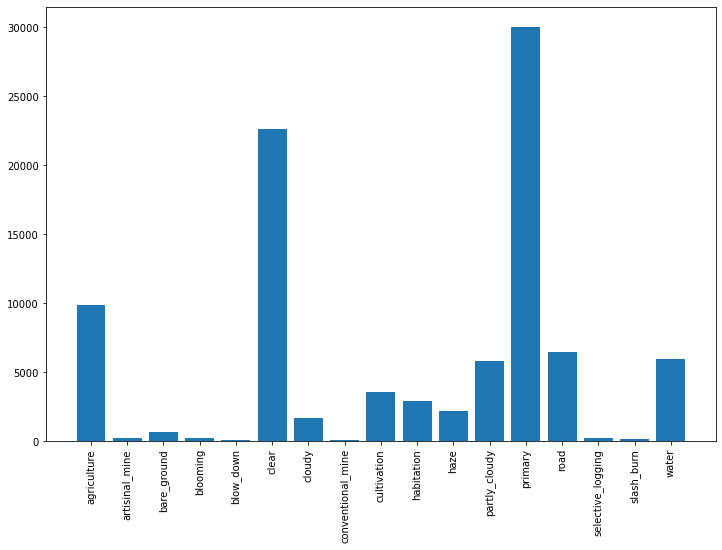

In [10]:
# Distribution of the labels

plt.figure(figsize=(12, 8))
            
plt.bar(range(len(tags_count)), list(tags_count), align='center')
plt.xticks(range(len(tags_count)), list(labels), rotation=90)

plt.show()

### Functions for metrics and plot

In [11]:
# Reference fbeta score for training
def fbeta_score_K(y_true, y_pred):
    beta = 2
    beta_squared = beta ** 2
    tp = K.sum(y_true * y_pred) + K.epsilon()
    fp = K.sum(y_pred) - tp
    fn = K.sum(y_true) - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    result = (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())
    return result


# calc_acc function for processing multi-label predictions into binarizer and calculate f2 score
def calc_acc(y_test, y_pred, labels=labels, threshold=0.2):
    
    array_labels = np.array(labels)
    test = y_test
    pred = y_pred
    
    # Binarize pred to 0 and 1...
    binarizer = Binarizer(threshold=threshold)
    pred = binarizer.fit_transform(pred)
    # 0 and 1 to False and True for boolean indexing...
    pred = pred > 0
    
    preds = []
    for row in pred:
        preds.append(array_labels[row])
    
    mlb = MultiLabelBinarizer(classes=array_labels)
    
    test = mlb.fit_transform(test)
    preds = mlb.transform(preds)
    score = fbeta_score(test, preds, beta=2, average='weighted')
    
    return test, preds, score


# plot function for f2 score and loss after training
def plot(result):
    train_history = pd.DataFrame(result)

    plt.plot(train_history['fbeta_score_K'])
    plt.plot(train_history['val_fbeta_score_K'])
    plt.title('model accuracy')
    plt.ylabel('fbeta_score_K')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    plt.plot(train_history['loss'])
    plt.plot(train_history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

### Function to process images for keras

In [12]:
def data_generator(X_train_files_o, y_train_o, base_flg):
    X_train_files, X_val_files, y_train, y_val = train_test_split(X_train_files_o, y_train_o, test_size=0.2, random_state=0)

    train_df = pd.DataFrame(list(zip(X_train_files, y_train)), columns = ['image_name', 'tags'])
    val_df = pd.DataFrame(list(zip(X_val_files, y_val)), columns = ['image_name', 'tags'])

    train_df['tags'] = train_df['tags']
    val_df['tags'] = val_df['tags']
    
    if base_flg == 1:
        train_datagen = ImageDataGenerator(
            rescale=1./255
            )
    else:
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=True
            )
        
    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        directory=TRAIN_PATH,
        x_col='image_name',
        y_col='tags',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
        )

    val_datagen = ImageDataGenerator(
        rescale=1./255
        )

    val_generator = val_datagen.flow_from_dataframe(
        val_df,
        directory=TRAIN_PATH,
        x_col='image_name',
        y_col='tags',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
        )

    test_datagen = ImageDataGenerator(
        rescale=1./255
        )

    test_generator = test_datagen.flow_from_dataframe(
        df_test,
        directory=TEST_PATH,
        x_col='image_name',
        y_col='tags',
        target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        classes=labels,
        shuffle=False,
        )

    return train_generator,val_generator,test_generator

### Baseline CNN

In [13]:
model_path = model_directory + 'CNN_Baseline_model' + '.h5'

In [14]:
### CNN_Baseline.py is shown here for illustration purpose
'''
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.backend import clear_session

import keras
from keras import backend as K
#from keras.regularizers import l2
#from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AveragePooling2D
#from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
#from keras.optimizers import Adam

def create_model():
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),

        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),

        Flatten(),
        Dense(17, activation='sigmoid') 
    ])

    return model
''';

In [15]:
# This cell was used for training and is shown here for illustration purpose
train_generator, val_generator, test_generator = data_generator(X_train_files_o, y_train_o,1)
'''
adam = Adam(learning_rate=LR)

cnn_base_model = baseline.create_model()

clear_session()

cnn_base_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[fbeta_score_K])

callbacks = [
    ModelCheckpoint(model_path, monitor='val_fbeta_score_K', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001)
]

history = cnn_base_model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks,
                   workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)

# print('here', history.history.keys())


cnn_base_model.load_weights(model_path)

y_pred_b = cnn_base_model.predict(test_generator, workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)
''';

Found 25906 validated image filenames belonging to 17 classes.
Found 6477 validated image filenames belonging to 17 classes.
Found 8096 validated image filenames belonging to 17 classes.


In [16]:
'''
cnn_base_model.save(model_path, save_format='h5')
''';

In [17]:
dependencies = {'fbeta_score_K': fbeta_score_K} # dependent function needed to load the model

cnn_base_model = load_model(model_path, custom_objects=dependencies)

y_pred_b = cnn_base_model.predict(test_generator, workers=WORKERS, use_multiprocessing=False, \
                                  max_queue_size=MAXQ)

In [18]:
test, pred, test_acc_cnn_base = calc_acc(y_test_o, y_pred_b)
print('Test F2 score =', round(test_acc_cnn_base, 3))
print(classification_report(test, pred, target_names=labels))

Test F2 score = 0.828
                   precision    recall  f1-score   support

      agriculture       0.70      0.77      0.73      2460
   artisinal_mine       0.50      0.49      0.50        61
      bare_ground       0.17      0.14      0.15       168
         blooming       0.07      0.05      0.06        73
        blow_down       0.25      0.08      0.12        26
            clear       0.94      0.96      0.95      5784
           cloudy       0.69      0.85      0.76       381
conventional_mine       0.40      0.17      0.24        23
      cultivation       0.39      0.39      0.39       927
       habitation       0.44      0.47      0.45       735
             haze       0.59      0.67      0.63       512
    partly_cloudy       0.86      0.87      0.86      1419
          primary       0.97      0.98      0.98      7534
             road       0.63      0.68      0.65      1619
selective_logging       0.11      0.07      0.09        70
       slash_burn       0.18     

/home/jihoon/anaconda3/envs/tf38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
'''
plot(history.history,'CNN_Baseline_train_history.csv')
print("Test Accuracy Score", calc_acc(y_test_o, y_pred_b))
''';

### Haze-removed Dataset Import

For next models in this notebook, a haze removed image dataset was used. Since the labels and image filenames are still the same as the original dataset imported above, the model can use the haze removed dataset by simply specifying `DATASET_PATH` and its dependencies again.

In [20]:
DATASET_PATH = 'dataset-haze-removed/'
TRAIN_PATH = DATASET_PATH + 'train_file'
TEST_PATH = DATASET_PATH + 'test_file'

# TRAIN_CSV_PATH = DATASET_PATH + 'train_label.csv'
# TEST_CSV_PATH = DATASET_PATH + 'test_label.csv'

### E. CNN_Baseline + Haze Removal + Data Augmentation + Batch Normalization + Drop out + Early Stopping

The hyperparameters of this model were optimised to increase its prediction F2 score as much as possible. The code used for this optimisation and the optimised hyperparameters are shown below:

In [21]:
### Hyperparameter optimisation code

'''
### Hyperparameter grid
DROPOUT_RATE = [0.1, 0.25, 0.5]
PATIENCE = [5, 10, 20]

### Import model
results = []

def run(BATCH_SIZE, DROPOUT_RATE, PATIENCE, LR):
    

    for dropout_rate in DROPOUT_RATE:
        print('\tdropout_rate =', dropout_rate)
        for patience in PATIENCE:
            print('\t\tpatience =', patience)
            
            train_generator, val_generator, test_generator = data_generator(X_train_files_o, y_train_o, \
                                                                            False, BATCH_SIZE)
            model_path = 'CNN_last_weights' + '.h5'
            adam = Adam(learning_rate=LR)
            cnn_batch_model = batchN.create_model(dropout_rate)
            clear_session() # tf backend
            cnn_batch_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[fbeta_score_K])

            callbacks = [
                ModelCheckpoint(model_path, monitor='val_fbeta_score_K', save_best_only=True, mode='max'),
                ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001),
                EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience),
            ]

            history = cnn_batch_model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, \
                                          callbacks=callbacks, workers=WORKERS, use_multiprocessing=False, \
                                          max_queue_size=MAXQ)



            cnn_batch_model.load_weights(model_path)

            y_pred = cnn_batch_model.predict(test_generator, workers=WORKERS, use_multiprocessing=False, \
                                             max_queue_size=MAXQ)
            
            test_score = calc_acc(y_test_o, y_pred)
            
            results.append({'dropout_rate':dropout_rate, 'patience':patience, 'history':history.history, \
                            'test_f2_score':test_score})
            
run(BATCH_SIZE, DROPOUT_RATE, PATIENCE, LR)
df_results = pd.DataFrame(results)
''';

In [22]:
### Optimised Hyperparameters
# DROPOUT_RATE = 0.1
# PATIENCE = 20
# EPOCHS = 100

In [23]:
model_path = model_directory + 'CNN_E_model_0.1_20' + '.h5'

In [24]:
### CNN_BatchN.py is shown here for illustration purpose
'''
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.backend import clear_session

import keras
from keras import backend as K
#from keras.regularizers import l2
#from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
#from keras.optimizers import Adam

def create_model(dropout):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
        BatchNormalization(),
	Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
	Dropout(dropout),

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
	BatchNormalization(),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
	Dropout(dropout),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
	BatchNormalization(),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
	Dropout(dropout),

        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
	BatchNormalization(),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
	Dropout(dropout),

        Flatten(),
        Dense(17, activation='sigmoid') 
    ])

    return model
''';

In [25]:
train_generator, val_generator, test_generator = data_generator(X_train_files_o, y_train_o, 0)

'''
adam = Adam(learning_rate=LR)

cnn_batch_model = batchN.create_model(DROPOUT_RATE)

clear_session()

cnn_batch_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[fbeta_score_K])

callbacks = [
    ModelCheckpoint(model_path, monitor='val_fbeta_score_K', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001),
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=PATIENCE),
]

history = cnn_batch_model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks,
                   workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)
''';

Found 25906 validated image filenames belonging to 17 classes.
Found 6477 validated image filenames belonging to 17 classes.
Found 8096 validated image filenames belonging to 17 classes.


In [26]:
'''
cnn_batch_model.save(model_path, save_format='h5')
''';

In [27]:
cnn_batch_model = load_model(model_path, custom_objects=dependencies)

y_pred_hr_da_do_es_bn = cnn_batch_model.predict(test_generator, workers=WORKERS, \
                                                use_multiprocessing=False, max_queue_size=MAXQ)

In [28]:
test, pred, test_acc_BatchN = calc_acc(y_test_o, y_pred_hr_da_do_es_bn)
print('Test F2 score =', round(test_acc_BatchN, 3))
print(classification_report(test, pred, target_names=labels))

Test F2 score = 0.9
                   precision    recall  f1-score   support

      agriculture       0.71      0.94      0.81      2460
   artisinal_mine       0.69      0.77      0.73        61
      bare_ground       0.32      0.26      0.29       168
         blooming       0.25      0.16      0.20        73
        blow_down       0.06      0.12      0.08        26
            clear       0.95      0.98      0.96      5784
           cloudy       0.66      0.93      0.77       381
conventional_mine       0.79      0.48      0.59        23
      cultivation       0.43      0.73      0.54       927
       habitation       0.67      0.66      0.66       735
             haze       0.50      0.80      0.62       512
    partly_cloudy       0.83      0.96      0.89      1419
          primary       0.97      1.00      0.98      7534
             road       0.64      0.92      0.76      1619
selective_logging       0.24      0.50      0.32        70
       slash_burn       0.11      0

In [29]:
'''
plot(history.history,'CNN_E_train_history.csv')
print("Test Accuracy Score", calc_acc(y_test_o, y_pred_hr_da_do_es_bn))
''';

### F. MobileNet + Haze Removal + Data Augmentation + Early Stopping

In [30]:
model_path = model_directory + 'CNN_F_model' + '.h5'

In [31]:
### Mobilenet.py is shown here for illustration purpose

'''
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.backend import clear_session

import keras
from keras import backend as K
#from keras.regularizers import l2
#from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AveragePooling2D, Input
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, Model
#from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet

# Define MobileNet model for Haze removal
def create_model():
    img = Input(shape = (128, 128, 3))
    model_mob = MobileNet(include_top=False, weights='imagenet', input_tensor=img, input_shape=None, pooling='avg')

    final_layer = model_mob.layers[-1].output
    dense_layer_1 = Dense(128, activation = 'relu')(final_layer)
    output_layer = Dense(17, activation = 'sigmoid')(dense_layer_1)

    model = Model(model_mob.input, output_layer)

    return model

''';

In [32]:
train_generator, val_generator, test_generator = data_generator(X_train_files_o, y_train_o,0)

'''
adam = Adam(learning_rate=LR)

mobnet_model = mobnet.create_model()

clear_session()
mobnet_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[fbeta_score_K])

callbacks = [
    ModelCheckpoint(model_path, monitor='val_fbeta_score_K', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001),
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=PATIENCE)
]

history = mobnet_model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks,
                   workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)
''';


Found 25906 validated image filenames belonging to 17 classes.
Found 6477 validated image filenames belonging to 17 classes.
Found 8096 validated image filenames belonging to 17 classes.


In [33]:
'''
mobnet_model.save(model_path, save_format='h5')
''';

In [34]:
mobnet_model = load_model(model_path, custom_objects=dependencies)

y_pred_mobnet = mobnet_model.predict(test_generator, workers=WORKERS, use_multiprocessing=False, \
                                     max_queue_size=MAXQ)

In [35]:
test, pred, test_acc_mobnet = calc_acc(y_test_o, y_pred_mobnet)
print('Test F2 score =', round(test_acc_mobnet, 3))
print(classification_report(test, pred, target_names=labels))

Test F2 score = 0.902
                   precision    recall  f1-score   support

      agriculture       0.76      0.92      0.83      2460
   artisinal_mine       0.68      0.72      0.70        61
      bare_ground       0.29      0.37      0.32       168
         blooming       0.24      0.14      0.18        73
        blow_down       0.33      0.08      0.12        26
            clear       0.95      0.98      0.96      5784
           cloudy       0.67      0.93      0.78       381
conventional_mine       0.60      0.39      0.47        23
      cultivation       0.48      0.69      0.57       927
       habitation       0.48      0.79      0.60       735
             haze       0.55      0.74      0.63       512
    partly_cloudy       0.83      0.95      0.88      1419
          primary       0.97      0.99      0.98      7534
             road       0.71      0.88      0.79      1619
selective_logging       0.28      0.30      0.29        70
       slash_burn       0.31     

In [36]:
'''
plot(history.history,'CNN_F_train_history.csv')
print("Test Accuracy Score", calc_acc(y_test_o, y_pred_mobnet))
''';

### G. VGG16 + Haze Removal + Data Augmentation + Early Stopping

In [37]:
model_path = model_directory + 'CNN_G_model' + '.h5'

In [38]:
### VGG16.py is shown here for illustration purpose

'''
import keras
import tensorflow as tf
from keras import backend as K
from keras.layers import Dense, Flatten, InputLayer
from keras.models import Sequential, Model
from tensorflow.keras.applications import VGG16


INPUT_SHAPE = (128, 128, 3)
 

def create_model():
    model = Sequential()
    model.add(InputLayer(INPUT_SHAPE))
    model.add(VGG16(weights='imagenet', include_top=False))
    model.add(Flatten())
    model.add(Dense(17, activation='sigmoid'))
    return model
''';

In [39]:
train_generator, val_generator, test_generator = data_generator(X_train_files_o, y_train_o,0)

'''
model_path = model_directory + 'CNN_G_model' + '.h5'


adam = Adam(learning_rate=LR)

vgg16_model = vgg16.create_model()

clear_session()
vgg16_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[fbeta_score_K])

callbacks = [
    ModelCheckpoint(model_path, monitor='val_fbeta_score_K', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, mode='min', min_lr=0.000001),
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=PATIENCE)
]

history = vgg16_model.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=callbacks,
                   workers=WORKERS, use_multiprocessing=False, max_queue_size=MAXQ)
''';

Found 25906 validated image filenames belonging to 17 classes.
Found 6477 validated image filenames belonging to 17 classes.
Found 8096 validated image filenames belonging to 17 classes.


In [40]:
'''
vgg16_model.save(model_path, save_format='h5')
''';

In [41]:
dependencies = {'fbeta_score_K': fbeta_score_K}
vgg16_model = load_model(model_path, custom_objects=dependencies)

y_pred_vgg16 = vgg16_model.predict(test_generator, workers=WORKERS, use_multiprocessing=False, \
                                   max_queue_size=MAXQ)

In [42]:
test, pred, test_acc_vgg16 = calc_acc(y_test_o, y_pred_vgg16)
print('Test F2 score =', round(test_acc_vgg16, 3))
print(classification_report(test, pred, target_names=labels))

Test F2 score = 0.907
                   precision    recall  f1-score   support

      agriculture       0.74      0.93      0.82      2460
   artisinal_mine       0.59      0.82      0.68        61
      bare_ground       0.39      0.24      0.30       168
         blooming       0.33      0.21      0.25        73
        blow_down       0.46      0.23      0.31        26
            clear       0.94      0.98      0.96      5784
           cloudy       0.74      0.90      0.81       381
conventional_mine       0.73      0.48      0.58        23
      cultivation       0.47      0.69      0.56       927
       habitation       0.61      0.77      0.68       735
             haze       0.59      0.73      0.66       512
    partly_cloudy       0.85      0.97      0.91      1419
          primary       0.96      1.00      0.98      7534
             road       0.66      0.93      0.77      1619
selective_logging       0.31      0.51      0.39        70
       slash_burn       0.83     

### XGBoost

In [43]:
import random
import xgboost as xgb
import scipy
from PIL import Image

In [44]:
# Set the seed to remove randomness
random_seed = 1
random.seed(random_seed)
np.random.seed(random_seed)

In [45]:
# # Function to extract the image features for XGBoost
# def extract_features(df, data_path):
#     im_features = df.copy()

#     N = len(im_features.image_name.values)

#     r_mean = np.zeros(N)
#     g_mean = np.zeros(N)
#     b_mean = np.zeros(N)

#     r_std = np.zeros(N)
#     g_std = np.zeros(N)
#     b_std = np.zeros(N)

#     r_max = np.zeros(N)
#     g_max = np.zeros(N)
#     b_max = np.zeros(N)

#     r_min = np.zeros(N)
#     g_min = np.zeros(N)
#     b_min = np.zeros(N)

#     r_kurtosis = np.zeros(N)
#     g_kurtosis = np.zeros(N)
#     b_kurtosis = np.zeros(N)
    
#     r_skewness = np.zeros(N)
#     g_skewness = np.zeros(N)
#     b_skewness = np.zeros(N)

#     for i, image_name in enumerate(im_features.image_name.values): 
#         im = Image.open(data_path + image_name)
#         im = np.array(im)[:,:,:3]

#         r = im[:,:,0].ravel()
#         g = im[:,:,1].ravel()
#         b = im[:,:,2].ravel()
        
#         r_mean[i] = np.mean(r)
#         g_mean[i] = np.mean(g)
#         b_mean[i] = np.mean(b)

#         r_std[i] = np.std(r)
#         g_std[i] = np.std(g)
#         b_std[i] = np.std(b)

#         r_max[i] = np.max(r)
#         g_max[i] = np.max(g)
#         b_max[i] = np.max(b)

#         r_min[i] = np.min(r)
#         g_min[i] = np.min(g)
#         b_min[i] = np.min(b)

#         r_kurtosis[i] = scipy.stats.kurtosis(r)
#         g_kurtosis[i] = scipy.stats.kurtosis(g)
#         b_kurtosis[i] = scipy.stats.kurtosis(b)
        
#         r_skewness[i] = scipy.stats.skew(r)
#         g_skewness[i] = scipy.stats.skew(g)
#         b_skewness[i] = scipy.stats.skew(b)


#     im_features['r_mean'] = r_mean
#     im_features['g_mean'] = g_mean
#     im_features['b_mean'] = b_mean

#     im_features['rgb_mean_mean'] = (r_mean + g_mean + b_mean)/3.0

#     im_features['r_std'] = r_std
#     im_features['g_std'] = g_std
#     im_features['b_std'] = b_std

#     im_features['rgb_mean_std'] = (r_std + g_std + b_std)/3.0

#     im_features['r_max'] = r_max
#     im_features['g_max'] = g_max
#     im_features['b_max'] = b_max

#     im_features['rgb_mean_max'] = (r_max + r_max + b_max)/3.0

#     im_features['r_min'] = r_min
#     im_features['g_min'] = g_min
#     im_features['b_min'] = b_min

#     im_features['rgb_mean_min'] = (r_min + g_min + b_min)/3.0

#     im_features['r_range'] = r_max - r_min
#     im_features['g_range'] = g_max - g_min
#     im_features['b_range'] = b_max - b_min

#     im_features['r_kurtosis'] = r_kurtosis
#     im_features['g_kurtosis'] = g_kurtosis
#     im_features['b_kurtosis'] = b_kurtosis
    
#     im_features['r_skewness'] = r_skewness
#     im_features['g_skewness'] = g_skewness
#     im_features['b_skewness'] = b_skewness
    
#     return im_features


In [46]:
# # Extract features
# print('Extracting train features')
# train_features = extract_features(df_train, TRAIN_PATH + '/')
# print('Extracting test features')
# test_features = extract_features(df_test, TEST_PATH + '/')

# # Save the extracted features
# import pickle

# train_feat = open(model_directory + 'train_features_xgb.pickle', 'wb')
# pickle.dump(train_features, train_feat, protocol=4)
# train_feat.close()

# test_feat = open(model_directory + 'test_features_xgb.pickle', 'wb')
# pickle.dump(test_features, test_feat, protocol=4)
# test_feat.close()

In [47]:
# Load the pickled features:
import pickle

pickle_XGtrain = open(model_directory + 'train_features_xgb.pickle', 'rb')
train_features = pickle.load(pickle_XGtrain)

pickle_yGtrain = open(model_directory + 'test_features_xgb.pickle', 'rb')
test_features = pickle.load(pickle_yGtrain)

In [48]:
# Prepare train dataset
X_train_xgb = np.array(train_features.drop(['image_name', 'tags'], axis=1))
mlb = MultiLabelBinarizer(classes=labels)
y_train_xgb = mlb.fit_transform(y_train_o)

n_classes = len(labels) # 17 classes in total
#Create X_test dataset
X_test_xgb = np.array(test_features.drop(['image_name', 'tags'], axis=1))

In [49]:
# Empty array for train and test predictions
train_pred_xgb = np.zeros((X_train_xgb.shape[0], n_classes)) # (num_of_train_images, n_classes=17)
y_pred_xgb = np.zeros((X_test_xgb.shape[0], n_classes)) # (num_of_test_images, n_classes=17)

The hyperparameters of this model were optimised to increase its prediction F2 score as much as possible. The code used for this optimisation and the optimised hyperparameters are shown below:

In [50]:
### Hyperparameter optimisation code

'''
# Hyperparameter grid
MAX_DEPTH = [2, 5, 10]
N_ESTIMATORS = [100, 200, 500]


def run(MAX_DEPTH, N_ESTIMATORS):
    results = []
    
    for max_depth in MAX_DEPTH:
        print('max_depth =', max_depth)
        for n_estimators in N_ESTIMATORS:
            print('n_estimators =', n_estimators)
#             train_pred_xgb = np.zeros((X_train_xgb.shape[0], n_classes)) # (num_of_train_images, n_classes=17)
            y_val_pred = np.zeros((X_val_xgb.shape[0], n_classes)) # (num_of_val_images, n_classes=17)
            y_test_pred = np.zeros((X_test_xgb.shape[0], n_classes)) # (num_of_test_images, n_classes=17)

            for i in tqdm(range(n_classes), miniters=1, leave=False): 
#                 print("i =", i, labels[i])
                model = xgb.XGBClassifier(max_depth=max_depth, learning_rate=0.1, n_estimators=n_estimators, \
                                          objective='binary:logistic', n_jobs=-1, \
                                          gamma=0, min_child_weight=1, max_delta_step=0, \
                                          subsample=1, colsample_bytree=1, colsample_bylevel=1, \
                                          reg_alpha=0, reg_lambda=1, scale_pos_weight=1, \
                                          base_score=0.5, seed=random_seed, \
                                          use_label_encoder=False, eval_metric='error', \
                                         )

                model.fit(X_train_xgb, y_train_xgb[:, i])
        
                y_val_pred[:, i] = model.predict_proba(X_val_xgb)[:,1] # prediction on test set
                y_test_pred[:, i] = model.predict_proba(X_test_xgb)[:,1] # prediction on test set

            val_score = calc_acc(y_val, y_val_pred, labels)
            test_score = calc_acc(y_test, y_test_pred, labels)
            print("val_f2_score = {} test_f2_score = {}".format(round(val_score, 3), round(test_score, 3)))

            results.append({'max_depth': max_depth, 'n_estimators': n_estimators, \
                            'val_f2_score': val_score, 'test_f2_score': test_score})
                
    return results
''';

#### XGBoost Training and Testing

In [51]:
for i in range(n_classes): 
    print("i =", i, labels[i])
    model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=200, \
                              objective='binary:logistic', n_jobs=-1, \
                              gamma=0, min_child_weight=1, max_delta_step=0, \
                              subsample=1, colsample_bytree=1, colsample_bylevel=1, \
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, \
                              base_score=0.5, seed=random_seed, \
                              use_label_encoder=False, eval_metric='error', \
                             )
    
    model.fit(X_train_xgb, y_train_xgb[:, i])
    train_pred_xgb[:, i] = model.predict_proba(X_train_xgb)[:,1] # prediction on train set
    y_pred_xgb[:, i] = model.predict_proba(X_test_xgb)[:,1] # prediction on test set

i = 0 agriculture


/home/jihoon/anaconda3/envs/tf38/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


i = 1 artisinal_mine
i = 2 bare_ground
i = 3 blooming
i = 4 blow_down
i = 5 clear
i = 6 cloudy
i = 7 conventional_mine
i = 8 cultivation
i = 9 habitation
i = 10 haze
i = 11 partly_cloudy
i = 12 primary
i = 13 road
i = 14 selective_logging
i = 15 slash_burn
i = 16 water


In [52]:
test, pred, test_score = calc_acc(y_test_o, y_pred_xgb)
print("Test F2 score =", test_score)
print(classification_report(test, pred, target_names=labels))

Test F2 score = 0.8719561482349918
                   precision    recall  f1-score   support

      agriculture       0.63      0.92      0.75      2460
   artisinal_mine       0.65      0.70      0.68        61
      bare_ground       0.33      0.21      0.26       168
         blooming       0.18      0.04      0.07        73
        blow_down       1.00      0.04      0.07        26
            clear       0.90      0.99      0.94      5784
           cloudy       0.68      0.88      0.77       381
conventional_mine       0.67      0.17      0.28        23
      cultivation       0.38      0.62      0.47       927
       habitation       0.52      0.76      0.62       735
             haze       0.55      0.78      0.64       512
    partly_cloudy       0.71      0.90      0.80      1419
          primary       0.96      1.00      0.98      7534
             road       0.53      0.87      0.66      1619
selective_logging       0.19      0.07      0.10        70
       slash_burn   